In [1]:
import seaborn as sns
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from itertools import product

In [3]:
df = pd.read_csv('sales_train.csv')

In [4]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

def get_split_points(data):
    train_split_points, val_split_points = [], []
    min_block_num = data.date_block_num.min()
    max_block_num = data.date_block_num.max()
    
    for date_block_num in range(min_block_num, min_block_num + 5):
        begin_val = data.date_block_num.searchsorted(max_block_num - 5 + date_block_num - min_block_num)
        begin_train = data.date_block_num.searchsorted(date_block_num)
        end_train = begin_val
        if date_block_num == min_block_num + 4:
            end_val = len(data)
        else:
            end_val = data.date_block_num.searchsorted(max_block_num - 5 + date_block_num - min_block_num + 1)
        val_split_points.append((begin_val, end_val))
        train_split_points.append((begin_train, end_train))
    return train_split_points, val_split_points
        

def get_train_val(data, train_split_points, val_split_points):
    for train_points, val_points in zip(train_split_points, val_split_points):
        train = data[train_points[0]:train_points[1]]
        val = data[val_points[0]:val_points[1]]
        yield train, val


In [5]:
df =downcast_dtypes(df)
df.dtypes

date               object
date_block_num      int16
shop_id             int16
item_id             int16
item_price        float32
item_cnt_day      float32
dtype: object

In [46]:
df.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [8]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.000000,1.0
1,03.01.2013,0,25,2552,899.000000,1.0
2,05.01.2013,0,25,2552,899.000000,-1.0
3,06.01.2013,0,25,2554,1709.050049,1.0
4,15.01.2013,0,25,2555,1099.000000,1.0


In [29]:
grouped = df.loc[df['item_cnt_day'] != -1.].groupby(['date_block_num', 'shop_id', 'item_id'])
train = grouped.agg({'item_price': 'mean', 'item_cnt_day': 'sum'}).reset_index()

train['item_freq'] = train['item_id'].map(train.item_id.value_counts())
train['date_block_num'] = train['date_block_num'] + 1

In [30]:
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_freq
0,1,0,32,221.0,6.0,785
1,1,0,33,347.0,3.0,562
2,1,0,35,247.0,1.0,75
3,1,0,43,221.0,1.0,9
4,1,0,51,128.5,2.0,168


In [7]:
train = train.loc[train['date_block_num'] % 12 != 0]

In [11]:
train.date_block_num.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34])

In [ ]:
val_months = [30, 31, 32, 33, 34]

In [14]:
train.dtypes

date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
item_freq           int64
dtype: object

### 0 count

In [4]:
storage = {i: {} for i in train.date_block_num.unique()}

for i, row in tqdm(train.iterrows()):
    shop_id = int(row['shop_id'])
    date_block_num = int(row['date_block_num'])
    if shop_id not in storage[date_block_num]:
        storage[date_block_num][shop_id] = set()
    storage[date_block_num][shop_id].add(int(row['item_id']))
    

NameError: name 'train' is not defined

In [48]:
new_features = pd.DataFrame({'date_block_num': pd.Series([], dtype='int'),
                             'shop_id': pd.Series([], dtype='int'),
                             'item_id': pd.Series([], dtype='int'),
                             'item_cnt_day': pd.Series([], dtype='int')
                            })

for date_block_num, info in tqdm(storage.items()):
    next_month = date_block_num + 1
    if next_month not in storage:
        continue
    for shop_id, items in info.items():
        for item in items:
            if shop_id in storage[next_month] and item not in storage[next_month][shop_id]:
                new_features = new_features.append({'date_block_num': next_month,
                             'shop_id': shop_id,
                             'item_id': item,
                             'item_cnt_day': 0
                            }, ignore_index=True)

100%|██████████| 34/34 [52:04<00:00, 91.88s/it] 


### Gen zero target

In [6]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in df['date_block_num'].unique():
    cur_shops = df[df['date_block_num']==block_num]['shop_id'].unique()
    cur_items = df[df['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

In [7]:
#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [8]:
gb = df.groupby(index_cols,as_index=False).agg({'item_cnt_day': 'sum'}) \
                                          .rename(columns={'item_cnt_day': 'target'})

all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [9]:
all_data.head()

,shop_id,item_id,date_block_num,target
139255,0,19,0,0.0
141495,0,27,0,0.0
144968,0,28,0,0.0
142661,0,29,0,0.0
138947,0,32,0,6.0


In [14]:
all_data.date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=int32)

In [11]:
all_data.dtypes

shop_id             int32
item_id             int32
date_block_num      int32
target            float32
dtype: object

# План

1. кол-во разных item_id в shop_id за последний месяц
2. сумма проданных всех item_id в shop_id за последний месяц
3. средние продажи магазина за последние три месяца
4. кол-во всего проданных item_id за последний месяц
5. кол-во всего проданных item_id за последний месяц в этом магазине

In [11]:
items = pd.read_csv('items.csv')

In [12]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [13]:
all_data = pd.merge(all_data,items,how='left',on=['item_id'])

In [14]:
item_categories = pd.read_csv('item_categories.csv')

In [15]:
all_data = pd.merge(all_data,item_categories,how='left',on=['item_category_id'])

In [16]:
all_data

,shop_id,item_id,date_block_num,target,item_name,item_category_id,item_category_name
0,0,19,0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD
1,0,27,0,0.0,"007 Legends [PS3, русская версия]",19,Игры - PS3
2,0,28,0,0.0,"007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания
3,0,29,0,0.0,"007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360
4,0,32,0,6.0,1+1,40,Кино - DVD
...,...,...,...,...,...,...,...
10913845,59,22162,33,0.0,ЯРОСТЬ,40,Кино - DVD
10913846,59,22163,33,0.0,ЯРОСТЬ ( регион),40,Кино - DVD
10913847,59,22164,33,0.0,ЯРОСТЬ (BD),37,Кино - Blu-Ray
10913848,59,22166,33,0.0,Язык запросов 1С:Предприятия [Цифровая версия],54,Книги - Цифра


In [47]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = df.groupby(index_cols,as_index=False).agg({'item_cnt_day': 'sum'}) \
                                          .rename(columns={'item_cnt_day': 'target'})
df.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [48]:
df

,shop_id,item_id,date_block_num,target
2,0,32,0,6.0
4,0,33,0,3.0
6,0,35,0,1.0
11,0,43,0,1.0
13,0,51,0,2.0
...,...,...,...,...
1608998,59,22087,33,6.0
1609030,59,22088,33,2.0
1609047,59,22091,33,1.0
1609073,59,22100,33,1.0


In [10]:
def add_shop_last_stat(data):
    grouped = data.groupby(['date_block_num', 'shop_id']).target.sum()
    grouped = grouped.reset_index()
    grouped['date_block_num'] += 1
    grouped.rename(columns={'target': 'prev_shop_sales'}, inplace=True)
    return pd.merge(data, grouped,how='left',on=['date_block_num', 'shop_id'])
    
def add_item_last_stat(data):
    grouped = data.groupby(['date_block_num', 'item_id']).target.sum()
    grouped = grouped.reset_index()
    grouped['date_block_num'] += 1
    grouped.rename(columns={'target': 'prev_item_sales'}, inplace=True)
    return pd.merge(data, grouped,how='left',on=['date_block_num', 'item_id'])

In [11]:
all_data = add_shop_last_stat(all_data)
all_data = add_item_last_stat(all_data)

In [12]:
shop_grouped = all_data[['date_block_num', 'shop_id', 'item_id', 'target']]
shop_grouped['date_block_num'] += 1
shop_grouped.rename(columns={'target': 'prev_shop_item_sales'}, inplace=True)
all_data = pd.merge(all_data, shop_grouped,how='left',on=['date_block_num', 'shop_id', 'item_id'])

shop_grouped['date_block_num'] += 1
shop_grouped.rename(columns={'prev_shop_item_sales': '2prev_shop_item_sales'}, inplace=True)
all_data = pd.merge(all_data, shop_grouped,how='left',on=['date_block_num', 'shop_id', 'item_id'])

shop_grouped['date_block_num'] += 1
shop_grouped.rename(columns={'2prev_shop_item_sales': '3prev_shop_item_sales'}, inplace=True)
all_data = pd.merge(all_data, shop_grouped,how='left',on=['date_block_num', 'shop_id', 'item_id'])

/home/ivan/venvs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ivan/venvs/kaggle/lib/python3.7/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
all_data

,shop_id,item_id,date_block_num,target,prev_shop_sales,prev_item_sales,prev_shop_item_sales,2prev_shop_item_sales,3prev_shop_item_sales
0,0,19,0,0.0,NaN,NaN,NaN,NaN,NaN
1,0,27,0,0.0,NaN,NaN,NaN,NaN,NaN
2,0,28,0,0.0,NaN,NaN,NaN,NaN,NaN
3,0,29,0,0.0,NaN,NaN,NaN,NaN,NaN
4,0,32,0,6.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10913845,59,22162,33,0.0,914.0,7.0,0.0,1.0,0.0
10913846,59,22163,33,0.0,914.0,20.0,0.0,0.0,NaN
10913847,59,22164,33,0.0,914.0,9.0,0.0,0.0,1.0
10913848,59,22166,33,0.0,914.0,5.0,0.0,0.0,0.0


In [14]:
all_data.date_block_num.max()

33

In [15]:
all_data.prev_shop_sales.value_counts()

2599.0    32949
1897.0    29884
1625.0    28813
1110.0    26119
1459.0    25757
          ...  
1533.0     5085
769.0      5085
2780.0     5085
2003.0     5085
1575.0     5085
Name: prev_shop_sales, Length: 1213, dtype: int64

In [38]:
prev_shop_mean = all_data.groupby(['date_block_num', 'shop_id']).target.mean().reset_index()

In [40]:
prev_shop_mean['date_block_num'] += 1

In [46]:
prev_shop_mean.rename(columns={'target': 'prev_shop_mean'}, inplace=True)
prev_shop_mean

,date_block_num,shop_id,prev_shop_mean
0,1,0,0.687369
1,1,1,0.363155
2,1,2,0.141220
3,1,3,0.094516
4,1,4,0.260505
...,...,...,...
1581,34,55,0.364308
1582,34,56,0.233327
1583,34,57,0.427859
1584,34,58,0.267135


In [47]:
all_data = pd.merge(all_data, prev_shop_mean, how='left', on=['date_block_num', 'shop_id'])

In [48]:
all_data

,shop_id,item_id,date_block_num,target,prev_shop_sales,prev_item_sales,prev_shop_item_sales,2prev_shop_item_sales,3prev_shop_item_sales,prev_shop_mean
0,0,19,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,27,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,28,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,29,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,32,0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
10913845,59,22162,33,0.0,914.0,7.0,0.0,1.0,0.0,0.179744
10913846,59,22163,33,0.0,914.0,20.0,0.0,0.0,NaN,0.179744
10913847,59,22164,33,0.0,914.0,9.0,0.0,0.0,1.0,0.179744
10913848,59,22166,33,0.0,914.0,5.0,0.0,0.0,0.0,0.179744


In [37]:
prev_shop_mean = all_data.groupby(['date_block_num', 'shop_id']).target.mean()
all_data['prev_shop_mean']

,shop_id,item_id,date_block_num,target,prev_shop_sales,prev_item_sales,prev_shop_item_sales,2prev_shop_item_sales,3prev_shop_item_sales
0,0,19,0,0.0,NaN,NaN,NaN,NaN,NaN
1,0,27,0,0.0,NaN,NaN,NaN,NaN,NaN
2,0,28,0,0.0,NaN,NaN,NaN,NaN,NaN
3,0,29,0,0.0,NaN,NaN,NaN,NaN,NaN
4,0,32,0,6.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10913845,59,22162,33,0.0,914.0,7.0,0.0,1.0,0.0
10913846,59,22163,33,0.0,914.0,20.0,0.0,0.0,NaN
10913847,59,22164,33,0.0,914.0,9.0,0.0,0.0,1.0
10913848,59,22166,33,0.0,914.0,5.0,0.0,0.0,0.0


In [21]:
set(all_data.loc[all_data['date_block_num'] == 28].shop_id.unique()) - set(all_data.loc[all_data['date_block_num'] == 29].shop_id.unique())

{29}

In [49]:
sales28week = all_data.loc[all_data['date_block_num'] == 28]
sales29week = all_data.loc[all_data['date_block_num'] == 29]

In [23]:
sales28week.shop_id

9556858     2
9556859     2
9556860     2
9556861     2
9556862     2
           ..
9789305    59
9789306    59
9789307    59
9789308    59
9789309    59
Name: shop_id, Length: 232452, dtype: int32

In [22]:
sales28week.shop_id.unique()

array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
       26, 27, 28, 29, 31, 34, 35, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 55, 56, 57, 58, 59], dtype=int32)

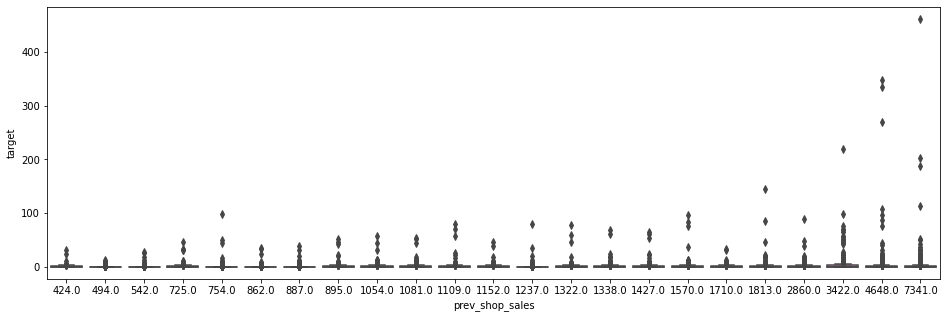

In [31]:
# x = sales28week.groupby('prev_shop_sales')
plt.figure(figsize=(16, 5))
ax = sns.boxplot(x="prev_shop_sales", y="target", data=sales28week.loc[(sales28week['shop_id'] > 30) & (sales28week['target'] > 0) ])
# sns.lineplot(sales28week.loc[sales28week["shop_id"] == 2].prev_shop_sales, sales28week.loc[sales28week["shop_id"] == 2].target)

/home/ivan/venvs/kaggle/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='prev_shop_sales', ylabel='target'>

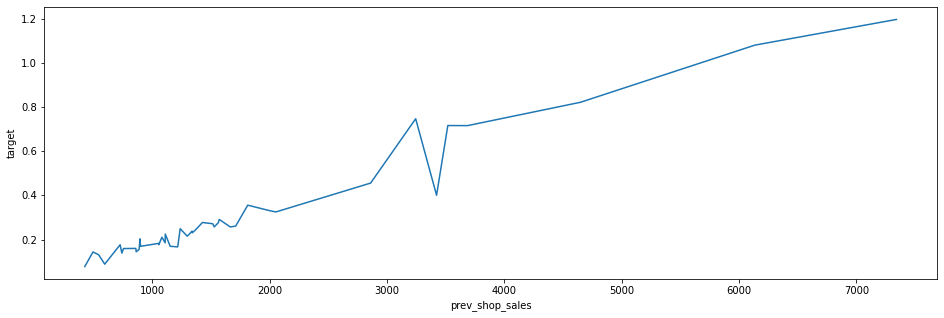

In [36]:
y = sales28week.groupby('prev_shop_sales').target.mean().reset_index()
plt.figure(figsize=(16, 5))
sns.lineplot(y['prev_shop_sales'], y['target'])

/home/ivan/venvs/kaggle/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='prev_shop_sales', ylabel='target'>

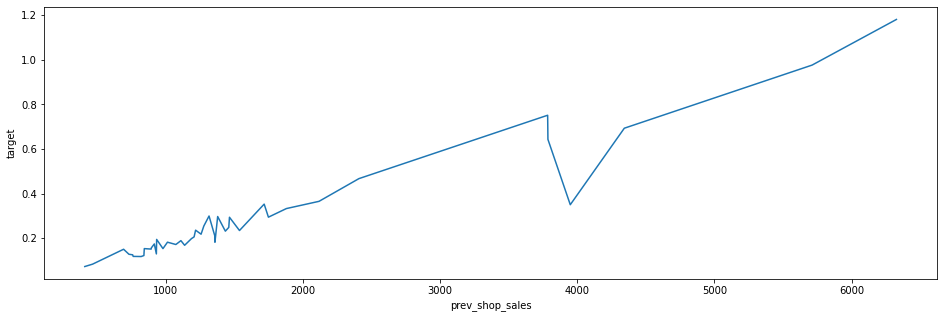

In [35]:
y = sales29week.groupby('prev_shop_sales').target.mean().reset_index()
plt.figure(figsize=(16, 5))
sns.lineplot(y['prev_shop_sales'], y['target'])

/home/ivan/venvs/kaggle/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ivan/venvs/kaggle/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '29 week')

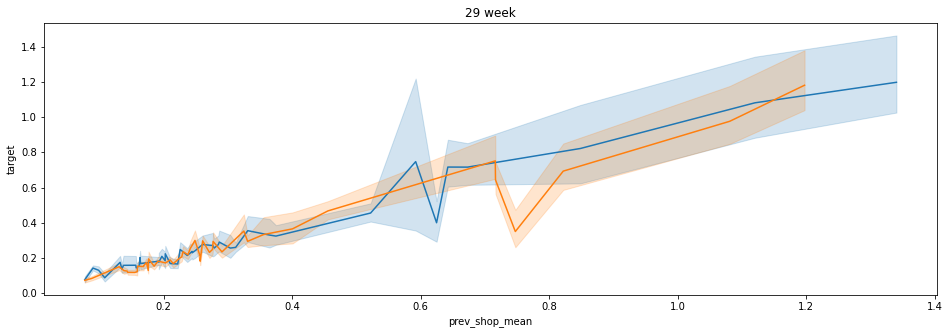

In [52]:
plt.figure(figsize=(16, 5))
sns.lineplot(sales28week['prev_shop_mean'], sales28week['target'])
plt.title('28 week')
sns.lineplot(sales29week['prev_shop_mean'], sales29week['target'])
plt.title('29 week')

/home/ivan/venvs/kaggle/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ivan/venvs/kaggle/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, '29 week')

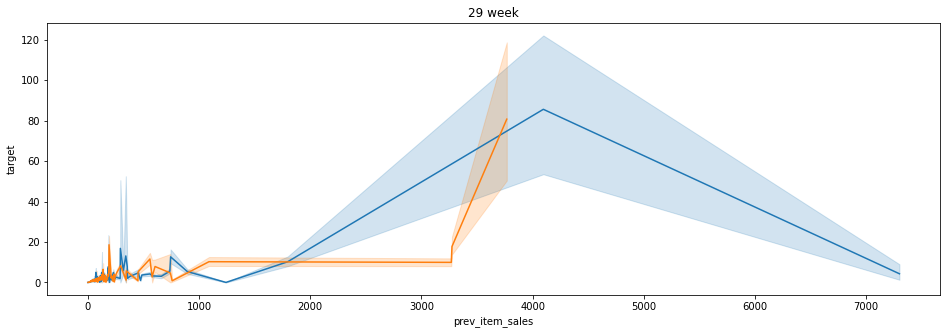

In [61]:
plt.figure(figsize=(16, 5))
sns.lineplot(sales28week['prev_item_sales'], sales28week['target'])
plt.title('28 week')
sns.lineplot(sales29week['prev_item_sales'], sales29week['target'])
plt.title('29 week')

/home/ivan/venvs/kaggle/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ivan/venvs/kaggle/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 200.0)

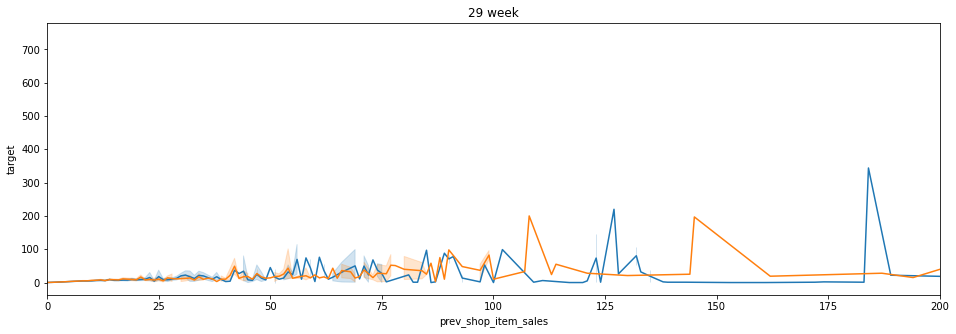

In [63]:
plt.figure(figsize=(16, 5))
sns.lineplot(sales28week['prev_shop_item_sales'], sales28week['target'])
plt.title('28 week')
sns.lineplot(sales29week['prev_shop_item_sales'], sales29week['target'])
plt.title('29 week')
plt.xlim([0, 200])

/home/ivan/venvs/kaggle/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'all_data')

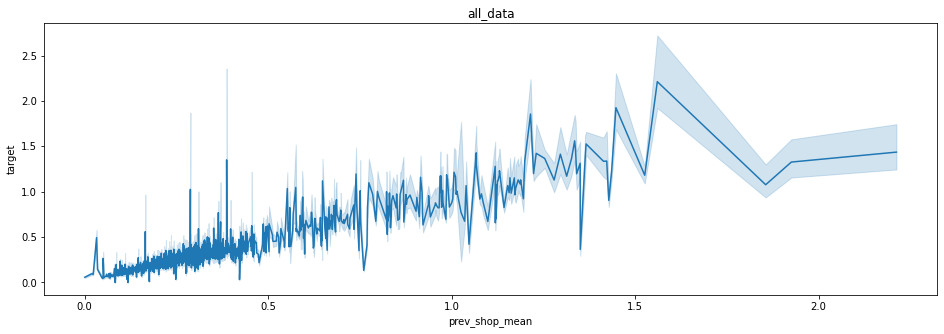

In [53]:
plt.figure(figsize=(16, 5))
sns.lineplot(all_data['prev_shop_mean'], all_data['target'])
plt.title('all_data')

In [56]:
print(np.corrcoef(all_data.loc[all_data['date_block_num'] > 1].fillna(0.)['prev_shop_mean'].values, all_data.loc[all_data['date_block_num'] > 1].fillna(0.)['target'].values)[0][1])

0.0685852762936595


In [59]:
print(np.corrcoef(all_data.loc[all_data['date_block_num'] > 1].fillna(0.)['prev_item_sales'].values, all_data.loc[all_data['date_block_num'] > 1].fillna(0.)['target'].values)[0][1])

0.4616261492709102


In [60]:

print(np.corrcoef(all_data.loc[all_data['date_block_num'] > 1].fillna(0.)['prev_shop_item_sales'].values, all_data.loc[all_data['date_block_num'] > 1].fillna(0.)['target'].values)[0][1])

0.6526597483032396


In [64]:
all_data

,shop_id,item_id,date_block_num,target,prev_shop_sales,prev_item_sales,prev_shop_item_sales,2prev_shop_item_sales,3prev_shop_item_sales,prev_shop_mean
0,0,19,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,27,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,28,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,29,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,32,0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
10913845,59,22162,33,0.0,914.0,7.0,0.0,1.0,0.0,0.179744
10913846,59,22163,33,0.0,914.0,20.0,0.0,0.0,NaN,0.179744
10913847,59,22164,33,0.0,914.0,9.0,0.0,0.0,1.0,0.179744
10913848,59,22166,33,0.0,914.0,5.0,0.0,0.0,0.0,0.179744


In [79]:
def add_cum_mean_target(data, by):
    cumsum = all_data.groupby(by).target.cumsum() - all_data['target']
    cumcnt = all_data.groupby(by).target.cumcount()
    data[by[:-2] + 'target_enc'] = cumsum / cumcnt
    data[by[:-2] + 'target_enc'].fillna(0.3343, inplace=True)
    return data

In [80]:
all_data = add_cum_mean_target(all_data, by='shop_id')

In [82]:

print(np.corrcoef(all_data.loc[all_data['date_block_num'] > 1].fillna(0.)['shop_target_enc'].values, all_data.loc[all_data['date_block_num'] > 1].fillna(0.)['target'].values)[0][1])

0.06963822132889055


## Learning

In [65]:
train_exp_on_prev = all_data.drop(['shop_id', 'item_id'], axis=1).fillna(0.)[all_data['date_block_num'] > 0]

In [72]:
train_exp_on_prev = all_data[['date_block_num', 'prev_shop_item_sales', 'prev_item_sales', 'target']].loc[all_data['date_block_num'] > 0].fillna(0.)

In [73]:
train_exp_on_prev

,date_block_num,prev_shop_item_sales,prev_item_sales,target
365175,1,0.0,0.0,0.0
365176,1,0.0,7.0,0.0
365177,1,0.0,8.0,0.0
365178,1,0.0,0.0,31.0
365179,1,0.0,0.0,11.0
...,...,...,...,...
10913845,33,0.0,7.0,0.0
10913846,33,0.0,20.0,0.0
10913847,33,0.0,9.0,0.0
10913848,33,0.0,5.0,0.0


In [30]:
train_exp_on_prev['grad'] = (train_exp_on_prev['prev_shop_item_sales'] - train_exp_on_prev['2prev_shop_item_sales']) \
                            /  (train_exp_on_prev['2prev_shop_item_sales'] + 1e-6)
train_exp_on_prev['roll_avg3'] = (train_exp_on_prev['prev_shop_item_sales'] + train_exp_on_prev['2prev_shop_item_sales'] \
                                  + train_exp_on_prev['3prev_shop_item_sales']) / 3.
train_exp_on_prev['rel_to_avg3'] = train_exp_on_prev['prev_shop_item_sales'] / (train_exp_on_prev['roll_avg3'] + 1e-6)

In [31]:
train_exp_on_prev

,date_block_num,target,prev_shop_sales,prev_item_sales,prev_shop_item_sales,2prev_shop_item_sales,3prev_shop_item_sales,grad,roll_avg3,rel_to_avg3
740903,2,0.0,488.0,3.0,0.0,1.0,0.0,-9.999990e-01,0.333333,0.000000
740904,2,0.0,488.0,8.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000
740905,2,1.0,488.0,861.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000
740906,2,1.0,488.0,628.0,4.0,0.0,0.0,4.000000e+06,1.333333,2.999998
740907,2,0.0,488.0,208.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
10913845,33,0.0,914.0,7.0,0.0,1.0,0.0,-9.999990e-01,0.333333,0.000000
10913846,33,0.0,914.0,20.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000
10913847,33,0.0,914.0,9.0,0.0,0.0,1.0,0.000000e+00,0.333333,0.000000
10913848,33,0.0,914.0,5.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000


In [74]:
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse

def fit_and_eval(data, algo='rfr'):
    train_split_points, val_split_points = get_split_points(data)

    val_results = []
    for train, val in get_train_val(data, train_split_points, val_split_points):

        X_train = np.array(train.drop(['date_block_num', 'target'], axis=1))
        X_val = np.array(val.drop(['date_block_num', 'target'], axis=1))
        y_train, y_val = np.array(train['target']), np.array(val['target'])
        if algo == 'rfr':
            model = RandomForestRegressor(n_estimators=64, n_jobs=-1)
            model.fit(X_train, y_train)
        else:
            model = CatBoostRegressor()
            model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=5, silent=True)
        val_results.append(mse(model.predict(X_val), y_val, squared=False))
    print('Model: ', algo)
    print('feat importancies: ', model.feature_importances_)
    print('rmse on val: ', val_results)
    

In [49]:
train_split_points, val_split_points = get_split_points(train_exp_on_prev)

val_results = []
for train, val in get_train_val(train_exp_on_prev, train_split_points, val_split_points):
    print(train.target.mean(), val.target.mean())

0.3379172 0.31101045
0.3351077 0.28585568
0.33596703 0.27605957
0.33661115 0.3080089
0.33658153 0.31499672


In [46]:
train_exp_on_prev

,date_block_num,target,prev_shop_sales,prev_item_sales,prev_shop_item_sales,2prev_shop_item_sales,3prev_shop_item_sales,grad,roll_avg3,rel_to_avg3
740903,2,0.0,488.0,3.0,0.0,1.0,0.0,-9.999990e-01,0.333333,0.000000
740904,2,0.0,488.0,8.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000
740905,2,1.0,488.0,861.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000
740906,2,1.0,488.0,628.0,4.0,0.0,0.0,4.000000e+06,1.333333,2.999998
740907,2,0.0,488.0,208.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
10913845,33,0.0,914.0,7.0,0.0,1.0,0.0,-9.999990e-01,0.333333,0.000000
10913846,33,0.0,914.0,20.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000
10913847,33,0.0,914.0,9.0,0.0,0.0,1.0,0.000000e+00,0.333333,0.000000
10913848,33,0.0,914.0,5.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.000000


In [45]:
fit_and_eval(train_exp_on_prev, algo='cbr')

Model:  cbr
feat importancies:  [10.95852829  9.74609059 40.31278302  3.82377712 10.06380028  2.50556026
 16.81203938  5.77742107]
rmse on val:  [3.182459859939672, 1.3978641376963732, 1.114385358256863, 1.2273208665919253, 5.545763369522032]


In [75]:
fit_and_eval(train_exp_on_prev, algo='cbr')

Model:  cbr
feat importancies:  [73.93647234 26.06352766]
rmse on val:  [3.5571813056594612, 1.6102898855571577, 0.9911863839321875, 1.2536121569408736, 5.525345691279435]


In [48]:
fit_and_eval(train_exp_on_prev[['prev_shop_item_sales', '2prev_shop_item_sales', '3prev_shop_item_sales', 'date_block_num', 'target']], algo='cbr')

Model:  cbr
feat importancies:  [66.62046086 13.64353384 19.73600529]
rmse on val:  [3.1257447399716223, 1.6018073371399866, 0.9766984752837955, 1.2229340755273368, 5.533629721502855]


In [45]:
fit_and_eval(train_exp_on_prev.drop(['grad', 'roll_avg3'], axis=1))

feat importancies:  [0.74100595 0.11895085 0.1400432 ]
rmse on val:  1.125603805486331


In [46]:
fit_and_eval(train_exp_on_prev.drop('grad', axis=1))

feat importancies:  [0.56343992 0.08326083 0.06938922 0.28391002]
rmse on val:  1.193758167328914


In [47]:
fit_and_eval(train_exp_on_prev.drop('roll_avg3', axis=1))

feat importancies:  [0.71491715 0.07875012 0.12152855 0.08480418]
rmse on val:  1.0768366367330497


In [49]:
fit_and_eval(train_exp_on_prev)

feat importancies:  [0.51322184 0.05620533 0.05329599 0.07099084 0.306286  ]
rmse on val:  1.1672512595568028


In [53]:
fit_and_eval(train_exp_on_prev.drop(['grad', 'roll_avg3'], axis=1), algo='cbr')
fit_and_eval(train_exp_on_prev.drop(['grad'], axis=1), algo='cbr')
fit_and_eval(train_exp_on_prev.drop(['roll_avg3'], axis=1), algo='cbr')
fit_and_eval(train_exp_on_prev, algo='cbr')

Model:  cbr
feat importancies:  [70.3542551  12.92937749 16.71636741]
rmse on val:  0.9716103112362297
Model:  cbr
feat importancies:  [58.155157    8.29713392 15.43641886 18.11129022]
rmse on val:  0.9854956737300289
Model:  cbr
feat importancies:  [67.49329742 11.82740182 15.07828604  5.60101472]
rmse on val:  0.981073576409658
Model:  cbr
feat importancies:  [59.29171146  5.48194795 11.80970446  7.38401797 16.03261815]
rmse on val:  0.9857327288191958


In [59]:
train_exp_on_prev['rel_to_avg3'] = train_exp_on_prev['prev_shop_item_sales'] / (train_exp_on_prev['roll_avg3'] + 1e-6)
train_exp_on_prev.drop(['roll_avg3'], inplace=True, axis=1)

In [61]:
fit_and_eval(train_exp_on_prev.drop(['grad'], axis=1), algo='cbr')
fit_and_eval(train_exp_on_prev, algo='cbr')

Model:  cbr
feat importancies:  [67.01559167 11.24400663 14.73452719  7.00587452]
rmse on val:  0.9909591268500632
Model:  cbr
feat importancies:  [64.64504045  8.62960181 19.27666254  2.85591658  4.59277862]
rmse on val:  0.9929648038065353


In [62]:
cumsum = all_data.groupby('item_id').target.cumsum() - all_data['target']
cumcnt = all_data.groupby('item_id').target.cumcount()
train_exp_on_prev['item_target_enc'] = cumsum / cumcnt
train_exp_on_prev['item_target_enc'].fillna(0.3343, inplace=True) 

In [63]:
train_exp_on_prev

,date_block_num,prev_shop_item_sales,2prev_shop_item_sales,3prev_shop_item_sales,target,grad,rel_to_avg3,item_target_enc
740903,2,0.0,1.0,0.0,0.0,-9.999990e-01,0.000000,0.109890
740904,2,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.175824
740905,2,0.0,0.0,0.0,1.0,0.000000e+00,0.000000,18.717391
740906,2,4.0,0.0,0.0,1.0,4.000000e+06,2.999998,13.652174
740907,2,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,5.571429
...,...,...,...,...,...,...,...,...
10913845,33,0.0,1.0,0.0,0.0,-9.999990e-01,0.000000,1.560268
10913846,33,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.585938
10913847,33,0.0,0.0,1.0,0.0,0.000000e+00,0.000000,1.238693
10913848,33,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.296170


In [69]:
fit_and_eval(train_exp_on_prev[['prev_shop_item_sales', 'item_target_enc', 'target', 'date_block_num']], algo='cbr')

Model:  cbr
feat importancies:  [74.35282364 25.64717636]
rmse on val:  1.0248124382601247


In [ ]:
fit_and_eval(train_exp_on_prev.drop(['grad', 'roll_avg3'], axis=1), algo='cbr')
fit_and_eval(train_exp_on_prev.drop(['grad'], axis=1), algo='cbr')
fit_and_eval(train_exp_on_prev.drop(['roll_avg3'], axis=1), algo='cbr')
fit_and_eval(train_exp_on_prev, algo='cbr')

In [42]:
train_exp_on_prev['roll_avg3'] = (train_exp_on_prev['prev_shop_item_sales'] + train_exp_on_prev['2prev_shop_item_sales'] \
                                  + train_exp_on_prev['3prev_shop_item_sales']) / 3.

fit_and_eval(train_exp_on_prev.drop('grad', axis=1))

feat importancies:  [0.42739133 0.06663467 0.07475902 0.43121498]
rmse on val:  1.1830866667821662


In [28]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=10, n_jobs=-1)

rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1)

In [31]:
from sklearn.metrics import mean_squared_error as mse

print(mse(rfr.predict(X_val), y_val, squared=False))

1.295426897061635


In [29]:
cbr.feature_importances_

array([70.3542551 , 12.92937749, 16.71636741])

In [26]:
from catboost import CatBoostRegressor
cbr = CatBoostRegressor()

cbr.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, early_stopping_rounds=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.258994
0:	learn: 2.9969847	test: 1.6988936	best: 1.6988936 (0)	total: 679ms	remaining: 11m 18s
1:	learn: 2.7425140	test: 1.3856147	best: 1.3856147 (1)	total: 1.2s	remaining: 9m 58s
2:	learn: 2.5745420	test: 1.2129284	best: 1.2129284 (2)	total: 1.82s	remaining: 10m 5s
3:	learn: 2.4719570	test: 1.0773454	best: 1.0773454 (3)	total: 2.49s	remaining: 10m 19s
4:	learn: 2.4015392	test: 1.0123099	best: 1.0123099 (4)	total: 3.13s	remaining: 10m 21s
5:	learn: 2.3567177	test: 0.9839445	best: 0.9839445 (5)	total: 3.75s	remaining: 10m 20s
6:	learn: 2.3281147	test: 0.9764400	best: 0.9764400 (6)	total: 4.36s	remaining: 10m 17s
7:	learn: 2.3069726	test: 0.9716103	best: 0.9716103 (7)	total: 5.2s	remaining: 10m 44s
8:	learn: 2.2913647	test: 0.9762302	best: 0.9716103 (7)	total: 5.91s	remaining: 10m 50s
9:	learn: 2.2803864	test: 0.9765329	best: 0.9716103 (7)	total: 6.54s	remaining: 10m 47s
10:	learn: 2.2724058	test: 0.9820530	best: 0.9716103 (7)	total: 7.15s	remaining: 10m 42s
11:	l

In [91]:
item_categories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [ ]:
def gen_feats(data):
    

In [88]:
all_data.head()

,shop_id,item_id,date_block_num,target
139255,0,19,0,0.0
141495,0,27,0,0.0
144968,0,28,0,0.0
142661,0,29,0,0.0
138947,0,32,0,6.0


In [28]:
train_split_points, val_split_points = get_split_points(all_data)

for train, val in get_train_val(all_data, train_split_points, val_split_points):
    item_freqs = train.loc[train.target>0].item_id.value_counts()
    new_train = []
    n = train.date_block_num.nunique() - 1
    for date_block_num in train.date_block_num.unique():
        data = train.loc[(train.target>0) & (train.date_block_num != date_block_num)] 
        freqs = data.item_id.value_counts() / n
        new_train.append(train.loc[train.date_block_num == 0]['item_id'].map(freqs))
    train['item_freq'] = train['item_id'].map(item_freqs)
    break

(0, 9789310) (9789310, 10013598)


In [64]:
new_train = []
n = train.date_block_num.nunique() - 1
for date_block_num in train.date_block_num.unique():
    data = train.loc[(train.target>0) & (train.date_block_num != date_block_num)] 
    freqs = data.item_id.value_counts() / n
    new_train.append(train.loc[train.date_block_num == date_block_num]['item_id'].map(freqs))

In [65]:
new_train = pd.concat(new_train).fillna(0.)

In [67]:
train['item_freq'] = new_train

/home/ivan/venvs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
train

,shop_id,item_id,date_block_num,target,item_freq
139255,0,19,0,0.0,0.000000
141495,0,27,0,0.0,1.250000
144968,0,28,0,0.0,2.428571
142661,0,29,0,0.0,0.285714
138947,0,32,0,6.0,24.107143
...,...,...,...,...,...
9742975,59,22159,28,0.0,0.000000
9742650,59,22162,28,1.0,3.607143
9741957,59,22164,28,0.0,3.464286
9746796,59,22166,28,0.0,0.678571


In [75]:
X_train = np.array(train.drop(['date_block_num', 'target'], axis=1))

In [77]:
X_val = np.array(val.drop(['date_block_num', 'target'], axis=1))

In [78]:
y_train, y_val = np.array(train['target']), np.array(val['target'])

In [80]:
from catboost import CatBoostRegressor

In [83]:
cbr = CatBoostRegressor()

cbr.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.261661
0:	learn: 3.0540400	test: 1.9982663	best: 1.9982663 (0)	total: 689ms	remaining: 11m 28s
1:	learn: 2.8944736	test: 1.8266129	best: 1.8266129 (1)	total: 1.37s	remaining: 11m 26s
2:	learn: 2.7950952	test: 1.7631488	best: 1.7631488 (2)	total: 2.06s	remaining: 11m 24s
3:	learn: 2.7353915	test: 1.7329458	best: 1.7329458 (3)	total: 2.72s	remaining: 11m 18s
4:	learn: 2.6821439	test: 1.7469845	best: 1.7329458 (3)	total: 3.28s	remaining: 10m 51s
5:	learn: 2.6580007	test: 1.7527856	best: 1.7329458 (3)	total: 3.85s	remaining: 10m 38s
6:	learn: 2.6330034	test: 1.7718184	best: 1.7329458 (3)	total: 4.41s	remaining: 10m 25s
7:	learn: 2.6238007	test: 1.7873559	best: 1.7329458 (3)	total: 4.99s	remaining: 10m 18s
8:	learn: 2.6194106	test: 1.8054189	best: 1.7329458 (3)	total: 5.67s	remaining: 10m 24s
9:	learn: 2.6152924	test: 1.8166128	best: 1.7329458 (3)	total: 6.25s	remaining: 10m 19s
10:	learn: 2.6083914	test: 1.8212920	best: 1.7329458 (3)	total: 6.87s	remaining: 10m 17s
1

93:	learn: 2.4124626	test: 1.6785922	best: 1.6669868 (77)	total: 56.5s	remaining: 9m 5s
94:	learn: 2.4123331	test: 1.6784927	best: 1.6669868 (77)	total: 57.1s	remaining: 9m 4s
95:	learn: 2.4115925	test: 1.6778546	best: 1.6669868 (77)	total: 57.7s	remaining: 9m 3s
96:	learn: 2.4108706	test: 1.6760100	best: 1.6669868 (77)	total: 58.3s	remaining: 9m 2s
97:	learn: 2.4106521	test: 1.6758935	best: 1.6669868 (77)	total: 59s	remaining: 9m 2s
98:	learn: 2.4105357	test: 1.6760159	best: 1.6669868 (77)	total: 59.5s	remaining: 9m 1s
99:	learn: 2.4098096	test: 1.6748723	best: 1.6669868 (77)	total: 1m	remaining: 9m 1s
100:	learn: 2.4096508	test: 1.6746262	best: 1.6669868 (77)	total: 1m	remaining: 9m 1s
101:	learn: 2.4094197	test: 1.6746170	best: 1.6669868 (77)	total: 1m 1s	remaining: 9m
102:	learn: 2.4089784	test: 1.6768682	best: 1.6669868 (77)	total: 1m 2s	remaining: 9m
103:	learn: 2.4087543	test: 1.6772246	best: 1.6669868 (77)	total: 1m 2s	remaining: 8m 59s
104:	learn: 2.4085539	test: 1.6774026	bes

184:	learn: 2.3855626	test: 1.6817019	best: 1.6669868 (77)	total: 1m 53s	remaining: 8m 20s
185:	learn: 2.3853792	test: 1.6819066	best: 1.6669868 (77)	total: 1m 54s	remaining: 8m 19s
186:	learn: 2.3853356	test: 1.6819672	best: 1.6669868 (77)	total: 1m 54s	remaining: 8m 19s
187:	learn: 2.3852778	test: 1.6819417	best: 1.6669868 (77)	total: 1m 55s	remaining: 8m 20s
188:	learn: 2.3851536	test: 1.6822381	best: 1.6669868 (77)	total: 1m 56s	remaining: 8m 20s
189:	learn: 2.3850883	test: 1.6821697	best: 1.6669868 (77)	total: 1m 57s	remaining: 8m 20s
190:	learn: 2.3850263	test: 1.6819939	best: 1.6669868 (77)	total: 1m 58s	remaining: 8m 20s
191:	learn: 2.3849437	test: 1.6819968	best: 1.6669868 (77)	total: 1m 58s	remaining: 8m 20s
192:	learn: 2.3847845	test: 1.6823662	best: 1.6669868 (77)	total: 1m 59s	remaining: 8m 19s
193:	learn: 2.3805386	test: 1.6735414	best: 1.6669868 (77)	total: 2m	remaining: 8m 19s
194:	learn: 2.3804259	test: 1.6740613	best: 1.6669868 (77)	total: 2m	remaining: 8m 18s
195:	le

275:	learn: 2.3653810	test: 1.6787810	best: 1.6669868 (77)	total: 2m 52s	remaining: 7m 32s
276:	learn: 2.3652810	test: 1.6788390	best: 1.6669868 (77)	total: 2m 52s	remaining: 7m 31s
277:	learn: 2.3652273	test: 1.6790746	best: 1.6669868 (77)	total: 2m 53s	remaining: 7m 30s
278:	learn: 2.3651388	test: 1.6788604	best: 1.6669868 (77)	total: 2m 54s	remaining: 7m 30s
279:	learn: 2.3649754	test: 1.6784466	best: 1.6669868 (77)	total: 2m 54s	remaining: 7m 29s
280:	learn: 2.3649295	test: 1.6789052	best: 1.6669868 (77)	total: 2m 55s	remaining: 7m 29s
281:	learn: 2.3648786	test: 1.6788953	best: 1.6669868 (77)	total: 2m 56s	remaining: 7m 28s
282:	learn: 2.3647660	test: 1.6789100	best: 1.6669868 (77)	total: 2m 56s	remaining: 7m 28s
283:	learn: 2.3646336	test: 1.6787768	best: 1.6669868 (77)	total: 2m 57s	remaining: 7m 27s
284:	learn: 2.3645944	test: 1.6787731	best: 1.6669868 (77)	total: 2m 58s	remaining: 7m 26s
285:	learn: 2.3642999	test: 1.6787867	best: 1.6669868 (77)	total: 2m 58s	remaining: 7m 26s

366:	learn: 2.3424396	test: 1.6730756	best: 1.6669868 (77)	total: 3m 51s	remaining: 6m 39s
367:	learn: 2.3423022	test: 1.6730464	best: 1.6669868 (77)	total: 3m 52s	remaining: 6m 38s
368:	learn: 2.3422827	test: 1.6731267	best: 1.6669868 (77)	total: 3m 52s	remaining: 6m 37s
369:	learn: 2.3421995	test: 1.6739086	best: 1.6669868 (77)	total: 3m 53s	remaining: 6m 37s
370:	learn: 2.3420922	test: 1.6739340	best: 1.6669868 (77)	total: 3m 53s	remaining: 6m 36s
371:	learn: 2.3417744	test: 1.6752606	best: 1.6669868 (77)	total: 3m 54s	remaining: 6m 35s
372:	learn: 2.3416494	test: 1.6755059	best: 1.6669868 (77)	total: 3m 55s	remaining: 6m 35s
373:	learn: 2.3413581	test: 1.6753874	best: 1.6669868 (77)	total: 3m 55s	remaining: 6m 34s
374:	learn: 2.3406489	test: 1.6753199	best: 1.6669868 (77)	total: 3m 56s	remaining: 6m 33s
375:	learn: 2.3405765	test: 1.6754753	best: 1.6669868 (77)	total: 3m 56s	remaining: 6m 33s
376:	learn: 2.3405273	test: 1.6755080	best: 1.6669868 (77)	total: 3m 57s	remaining: 6m 32s

457:	learn: 2.3273796	test: 1.6791542	best: 1.6669868 (77)	total: 4m 47s	remaining: 5m 40s
458:	learn: 2.3273552	test: 1.6791627	best: 1.6669868 (77)	total: 4m 48s	remaining: 5m 39s
459:	learn: 2.3273236	test: 1.6788928	best: 1.6669868 (77)	total: 4m 48s	remaining: 5m 39s
460:	learn: 2.3272028	test: 1.6785745	best: 1.6669868 (77)	total: 4m 49s	remaining: 5m 38s
461:	learn: 2.3271843	test: 1.6786384	best: 1.6669868 (77)	total: 4m 50s	remaining: 5m 37s
462:	learn: 2.3271551	test: 1.6786638	best: 1.6669868 (77)	total: 4m 50s	remaining: 5m 37s
463:	learn: 2.3271372	test: 1.6786406	best: 1.6669868 (77)	total: 4m 51s	remaining: 5m 36s
464:	learn: 2.3270911	test: 1.6786798	best: 1.6669868 (77)	total: 4m 52s	remaining: 5m 35s
465:	learn: 2.3270132	test: 1.6786656	best: 1.6669868 (77)	total: 4m 52s	remaining: 5m 35s
466:	learn: 2.3269519	test: 1.6786570	best: 1.6669868 (77)	total: 4m 53s	remaining: 5m 34s
467:	learn: 2.3269295	test: 1.6788108	best: 1.6669868 (77)	total: 4m 53s	remaining: 5m 34s

548:	learn: 2.3214733	test: 1.6810739	best: 1.6669868 (77)	total: 5m 48s	remaining: 4m 46s
549:	learn: 2.3212275	test: 1.6810721	best: 1.6669868 (77)	total: 5m 49s	remaining: 4m 45s
550:	learn: 2.3211947	test: 1.6810729	best: 1.6669868 (77)	total: 5m 49s	remaining: 4m 44s
551:	learn: 2.3211660	test: 1.6812233	best: 1.6669868 (77)	total: 5m 50s	remaining: 4m 44s
552:	learn: 2.3210999	test: 1.6810900	best: 1.6669868 (77)	total: 5m 50s	remaining: 4m 43s
553:	learn: 2.3209412	test: 1.6823367	best: 1.6669868 (77)	total: 5m 51s	remaining: 4m 43s
554:	learn: 2.3208964	test: 1.6822215	best: 1.6669868 (77)	total: 5m 52s	remaining: 4m 42s
555:	learn: 2.3208748	test: 1.6822253	best: 1.6669868 (77)	total: 5m 52s	remaining: 4m 41s
556:	learn: 2.3208104	test: 1.6822226	best: 1.6669868 (77)	total: 5m 53s	remaining: 4m 41s
557:	learn: 2.3206802	test: 1.6822482	best: 1.6669868 (77)	total: 5m 54s	remaining: 4m 40s
558:	learn: 2.3206655	test: 1.6821952	best: 1.6669868 (77)	total: 5m 54s	remaining: 4m 39s

639:	learn: 2.3159656	test: 1.6831069	best: 1.6669868 (77)	total: 6m 46s	remaining: 3m 48s
640:	learn: 2.3153254	test: 1.6841611	best: 1.6669868 (77)	total: 6m 47s	remaining: 3m 48s
641:	learn: 2.3152957	test: 1.6843095	best: 1.6669868 (77)	total: 6m 48s	remaining: 3m 47s
642:	learn: 2.3152005	test: 1.6842831	best: 1.6669868 (77)	total: 6m 48s	remaining: 3m 46s
643:	learn: 2.3151776	test: 1.6839871	best: 1.6669868 (77)	total: 6m 49s	remaining: 3m 46s
644:	learn: 2.3146861	test: 1.6849704	best: 1.6669868 (77)	total: 6m 49s	remaining: 3m 45s
645:	learn: 2.3146658	test: 1.6849338	best: 1.6669868 (77)	total: 6m 50s	remaining: 3m 44s
646:	learn: 2.3146242	test: 1.6848933	best: 1.6669868 (77)	total: 6m 51s	remaining: 3m 44s
647:	learn: 2.3145773	test: 1.6848516	best: 1.6669868 (77)	total: 6m 51s	remaining: 3m 43s
648:	learn: 2.3145511	test: 1.6848882	best: 1.6669868 (77)	total: 6m 52s	remaining: 3m 43s
649:	learn: 2.3145304	test: 1.6849765	best: 1.6669868 (77)	total: 6m 53s	remaining: 3m 42s

730:	learn: 2.3104926	test: 1.6954610	best: 1.6669868 (77)	total: 7m 44s	remaining: 2m 50s
731:	learn: 2.3104695	test: 1.6954646	best: 1.6669868 (77)	total: 7m 44s	remaining: 2m 50s
732:	learn: 2.3104329	test: 1.6954937	best: 1.6669868 (77)	total: 7m 45s	remaining: 2m 49s
733:	learn: 2.3103979	test: 1.6954931	best: 1.6669868 (77)	total: 7m 45s	remaining: 2m 48s
734:	learn: 2.3103833	test: 1.6954987	best: 1.6669868 (77)	total: 7m 46s	remaining: 2m 48s
735:	learn: 2.3103558	test: 1.6955062	best: 1.6669868 (77)	total: 7m 47s	remaining: 2m 47s
736:	learn: 2.3102519	test: 1.6959232	best: 1.6669868 (77)	total: 7m 47s	remaining: 2m 46s
737:	learn: 2.3102405	test: 1.6959442	best: 1.6669868 (77)	total: 7m 48s	remaining: 2m 46s
738:	learn: 2.3102266	test: 1.6959294	best: 1.6669868 (77)	total: 7m 49s	remaining: 2m 45s
739:	learn: 2.3101599	test: 1.6959599	best: 1.6669868 (77)	total: 7m 49s	remaining: 2m 45s
740:	learn: 2.3101429	test: 1.6959333	best: 1.6669868 (77)	total: 7m 50s	remaining: 2m 44s

821:	learn: 2.3039997	test: 1.7086970	best: 1.6669868 (77)	total: 8m 42s	remaining: 1m 53s
822:	learn: 2.3039886	test: 1.7086840	best: 1.6669868 (77)	total: 8m 42s	remaining: 1m 52s
823:	learn: 2.3039259	test: 1.7087248	best: 1.6669868 (77)	total: 8m 43s	remaining: 1m 51s
824:	learn: 2.3039182	test: 1.7087052	best: 1.6669868 (77)	total: 8m 43s	remaining: 1m 51s
825:	learn: 2.3037172	test: 1.7108827	best: 1.6669868 (77)	total: 8m 44s	remaining: 1m 50s
826:	learn: 2.3037056	test: 1.7108850	best: 1.6669868 (77)	total: 8m 45s	remaining: 1m 49s
827:	learn: 2.3036900	test: 1.7109076	best: 1.6669868 (77)	total: 8m 45s	remaining: 1m 49s
828:	learn: 2.3036773	test: 1.7109041	best: 1.6669868 (77)	total: 8m 46s	remaining: 1m 48s
829:	learn: 2.3036338	test: 1.7109252	best: 1.6669868 (77)	total: 8m 47s	remaining: 1m 47s
830:	learn: 2.3036231	test: 1.7108986	best: 1.6669868 (77)	total: 8m 47s	remaining: 1m 47s
831:	learn: 2.3033332	test: 1.7117368	best: 1.6669868 (77)	total: 8m 48s	remaining: 1m 46s

912:	learn: 2.2989010	test: 1.7099662	best: 1.6669868 (77)	total: 9m 40s	remaining: 55.3s
913:	learn: 2.2988763	test: 1.7099612	best: 1.6669868 (77)	total: 9m 40s	remaining: 54.6s
914:	learn: 2.2987378	test: 1.7099620	best: 1.6669868 (77)	total: 9m 41s	remaining: 54s
915:	learn: 2.2987164	test: 1.7099615	best: 1.6669868 (77)	total: 9m 42s	remaining: 53.4s
916:	learn: 2.2986884	test: 1.7100334	best: 1.6669868 (77)	total: 9m 42s	remaining: 52.7s
917:	learn: 2.2986804	test: 1.7100367	best: 1.6669868 (77)	total: 9m 43s	remaining: 52.1s
918:	learn: 2.2986622	test: 1.7101324	best: 1.6669868 (77)	total: 9m 43s	remaining: 51.5s
919:	learn: 2.2986467	test: 1.7101253	best: 1.6669868 (77)	total: 9m 44s	remaining: 50.8s
920:	learn: 2.2986092	test: 1.7101427	best: 1.6669868 (77)	total: 9m 45s	remaining: 50.2s
921:	learn: 2.2985700	test: 1.7100998	best: 1.6669868 (77)	total: 9m 45s	remaining: 49.6s
922:	learn: 2.2985368	test: 1.7100598	best: 1.6669868 (77)	total: 9m 46s	remaining: 48.9s
923:	learn: 

In [87]:
train

,shop_id,item_id,date_block_num,target,item_freq
139255,0,19,0,0.0,0.000000
141495,0,27,0,0.0,1.250000
144968,0,28,0,0.0,2.428571
142661,0,29,0,0.0,0.285714
138947,0,32,0,6.0,24.107143
...,...,...,...,...,...
9742975,59,22159,28,0.0,0.000000
9742650,59,22162,28,1.0,3.607143
9741957,59,22164,28,0.0,3.464286
9746796,59,22166,28,0.0,0.678571


In [86]:
cbr.feature_importances_

array([27.55250797, 35.26765631, 37.17983572])

In [69]:
val['item_freq'] = val['item_id'].map(train.loc[(train.target>0)].item_id.value_counts() / train.date_block_num.nunique()).fillna(0.)

/home/ivan/venvs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
val

,shop_id,item_id,date_block_num,target,item_freq
9964797,2,30,29,0.0,16.034483
9964713,2,31,29,0.0,15.241379
9962775,2,32,29,0.0,24.551724
9961600,2,33,29,0.0,17.310345
9963341,2,38,29,0.0,1.620690
...,...,...,...,...,...
9941493,59,22159,29,0.0,0.310345
9941501,59,22162,29,0.0,4.172414
9941500,59,22164,29,0.0,3.793103
9945699,59,22166,29,0.0,0.689655


In [ ]:
new_val = train.loc[(train.target>0)].item_id.value_counts() / train.date_block_num.nunique()

In [32]:
train.loc[train.target>0].item_id.value_counts()

5822     1261
2308     1232
2808     1222
2416     1177
5272     1169
         ... 
13596       1
7449        1
12867       1
1605        1
0           1
Name: item_id, Length: 20287, dtype: int64

In [ ]:
item_freqs = df.item_id.value_coun 